## 5.2 합성곱 신경망 맛보기
- fashion mnist 데이터셋을 사용하여

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# cpu 혹은 gpu 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# 데이터 내려받기
# 이때 transform을 통해 이미지를 텐서 0-1로 변
train_dataset = torchvision.datasets.FashionMNIST("C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw



100.0%


Extracting C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw



100.0%


Extracting C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw



100.0%

Extracting C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:/Users/sshyu/OneDrive/바탕 화면/Euron/chap05/data\FashionMNIST\raw



In [5]:
# 데이터를 데이터로더에 연결
# 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가 무작위로 섞이도록 할 수 있음
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

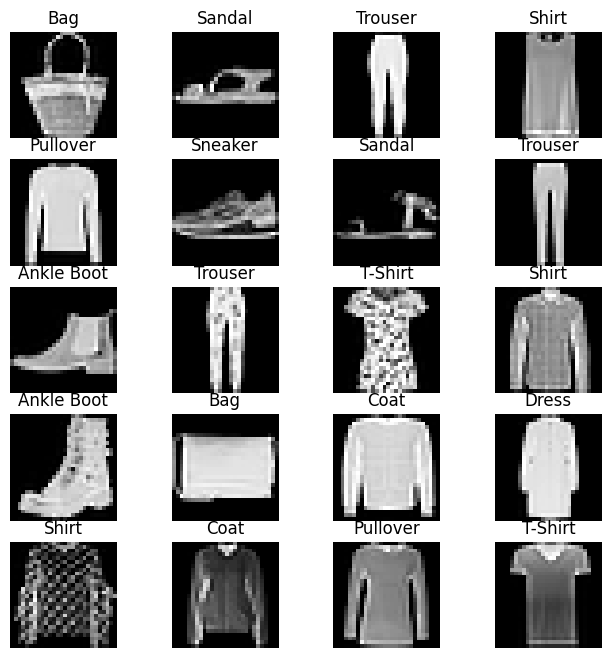

In [6]:
# 분류에 사용될 클래스 정의
# 먼저 20개의 이미지를 레이블 정보와 함께 출력해보기
# np.random.randint를 통해 0-traindataset의 길이의 분포에서 랜덤한 숫자를 한개 생성 가능
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
# 심층 신경망 모델 생성
# CNN과의 비교를 위해
class FashionDNN(nn.Module):
    def __init__(self):
        # __init__은 객체가 갖는 속성의 값을 초기화하여
        # 객체가 생성될 때 자동으로 호출
        super(FashionDNN,self).__init__()
        # 단순 선형 회귀 모델 만기기
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        # p 만큼의 비율로 텐서 값이 0이됨.
        # 0이 되지 않는 값들은 기존 값에 1/(1-p) 곱해짐
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)
        # 순전파학 
    def forward(self,input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        # 활성화 함수
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

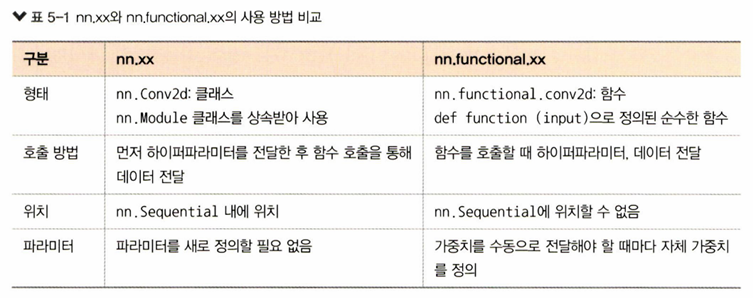

In [8]:
# 모델 학습 시키기 전
# 손실함수 학습률 옵티마이저 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
# 심층 신경망 총한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 모델과 데이터가 동일한 장치에 있어야 
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        # autograd를 통해 자동미분에 대한 값을 tape를 사용하여 저장
        # backward 단계에서 저장된 값을 꺼내서 사용함
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


C:\Users\sshyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.6074342131614685, Accuracy: 83.31999969482422%
Iteration: 1000, Loss: 0.4521849751472473, Accuracy: 84.80000305175781%
Iteration: 1500, Loss: 0.38517165184020996, Accuracy: 84.08000183105469%
Iteration: 2000, Loss: 0.38835376501083374, Accuracy: 85.25%
Iteration: 2500, Loss: 0.23720408976078033, Accuracy: 86.41999816894531%
Iteration: 3000, Loss: 0.2921989858150482, Accuracy: 86.55999755859375%


In [10]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            # __init에서 모델 정의 뿐만 아니라
            # forward에서 구현될 순전파를 layer 형태로 가독성이 뛰어난 코드로 작성 가능
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # in_channels는 입력 채널수로 흑백이미지는 1, RGB 이미지는 3
            # out_channels는 출력 채널수
            # kernel_size는 커널 크기로 이밎 특징을 찾아내기 위한 공용 파라미터
            # 입력 데이터를 stride 간격으로 순회하면서 합성곱을 계산함
            # padding은 패딩크기로 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움
            nn.BatchNorm2d(32),
            # 각 배치단위별 다양한 분포를 가지더라도 평균과 분산을 이용해 정규화하는것
            # 분포를 가우시안 형태로 만듦
            nn.ReLU(),
            # MaxPool2d는 이미지 크기를 축소시키는 용도로
            # 출력 데이터의 크기를 줄이거나 특징 데이터를 강조하는 용도로 사용됨
            # kernel_size 2x2 행렬로 구성되 가중치
            # 이동할 간격인 stride로 stride 값이 커지면 출력 크기는 작아짐
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 클래스를 분류하기 위해서는
        # 이미지 형태의 데이터를 1타원 배열 형태로 변환하여 작업해야 함
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [11]:
# 합성곱 네트워크를 위한 파라미터 정의

learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
# CNN 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.42208123207092285, Accuracy: 87.8499984741211%
Iteration: 1000, Loss: 0.34920239448547363, Accuracy: 88.62999725341797%
Iteration: 1500, Loss: 0.3815256953239441, Accuracy: 87.27999877929688%
Iteration: 2000, Loss: 0.22794003784656525, Accuracy: 89.51000213623047%
Iteration: 2500, Loss: 0.1316724419593811, Accuracy: 89.37000274658203%
Iteration: 3000, Loss: 0.2404506653547287, Accuracy: 89.62999725341797%


심층 신경망에 비해 정확도가 약간 높음을 확인!